In [11]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import ta
import MetaTrader5 as mt5
import pytz
from datetime import datetime
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volume import OnBalanceVolumeIndicator

In [12]:
#Settings
mpl.style.use('seaborn')
default_fig_size = (20, 20) # Width , Height

### Initialize MT5

In [13]:
mt5.initialize()

True

### Functions

In [14]:
def get_rates(symbols, timeframe, date_from, date_to):
    dict_rates = {}
    for symbol in symbols:
        rates = mt5.copy_rates_range(symbol, timeframe, date_from, date_to)
        df = pd.DataFrame(data=rates)
        df["time"] = pd.to_datetime(df["time"], unit='s')
        df = df.set_index("time")
        dict_rates[symbol] = df        
    return dict_rates

### Reading data from MT5

In [15]:
# definimos o fuso horário como UTC
timezone = pytz.timezone("Etc/UTC")
date_from = datetime(2018, 1, 1, tzinfo=timezone)
date_to = datetime(2020, 2, 1, tzinfo=timezone)
dfs = get_rates(["EURUSD"], mt5.TIMEFRAME_D1, date_from, date_to)
df = dfs["EURUSD"]
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2018-01-02,1.20088,1.20812,1.20007,1.20579,92779,1,0
2018-01-03,1.20579,1.20661,1.20010,1.20142,100595,1,0
2018-01-04,1.20142,1.20889,1.20043,1.20678,109715,1,0
2018-01-05,1.20678,1.20828,1.20206,1.20298,113628,1,0
2018-01-08,1.20268,1.20523,1.19556,1.19669,88921,1,0
...,...,...,...,...,...,...,...
2020-01-27,1.10295,1.10375,1.10096,1.10184,33777,1,0
2020-01-28,1.10185,1.10251,1.09977,1.10220,28331,1,0
2020-01-29,1.10219,1.10277,1.09922,1.10099,28043,1,0


## Trend Study

In [16]:
indicator_adx = ADXIndicator(high=df["high"], low=df["low"], close=df["close"], n=20, fillna=True)

In [17]:
adx = indicator_adx.adx()
adx_neg = indicator_adx.adx_neg()
adx_pos = indicator_adx.adx_pos()

adx_neg_shifted = adx_neg.shift(-1)
adx_pos_shifted = adx_pos.shift(-1)

divergence_signals = ((adx_neg_shifted < adx_pos) & (adx_neg > adx_pos)) | ((adx_pos_shifted > adx_neg) & (adx_pos < adx_neg))

c:\users\tenta\.conda\envs\investing-broker\lib\site-packages\ta\trend.py:643: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\tenta\.conda\envs\investing-broker\lib\site-packages\ta\trend.py:647: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


Text(0, 0.5, 'ADX')

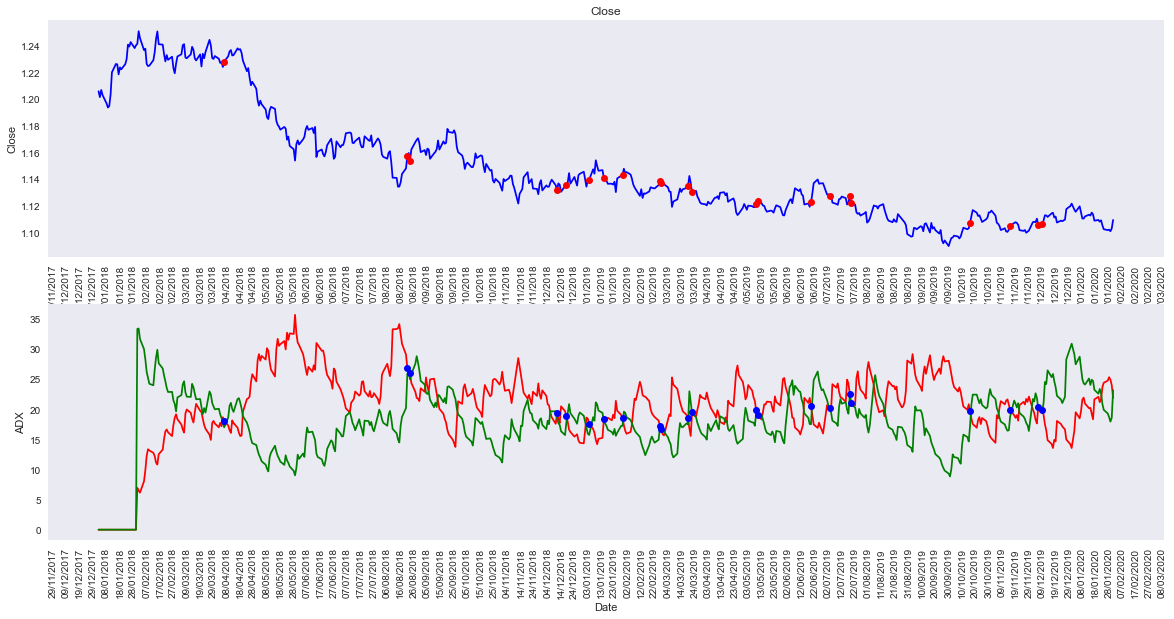

In [18]:
plt.figure(figsize=default_fig_size)

close_divergence_adx = df[divergence_signals]['close']

ax = plt.subplot(411)
ax.grid()
ax.set_title(u"Close")
ax.xaxis.set_major_locator(DayLocator(interval=10))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.plot(df['close'], 'b', close_divergence_adx, 'ro')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Close')

adx_divergence = adx_neg[divergence_signals]

ax = plt.subplot(412)
ax.grid()
ax.set_title(u"")
ax.xaxis.set_major_locator(DayLocator(interval=10))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.plot(adx_neg, 'r', adx_pos, 'g', adx_divergence, 'bo')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('ADX')

## Bollinger Study

In [19]:
# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df["close"], n=20, ndev=2)
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator() > 0
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator() > 0

close_sell_signal = df[df['bb_bbhi']]['close']
close_buy_signal = df[df['bb_bbli']]['close']

Text(0, 0.5, 'Close')

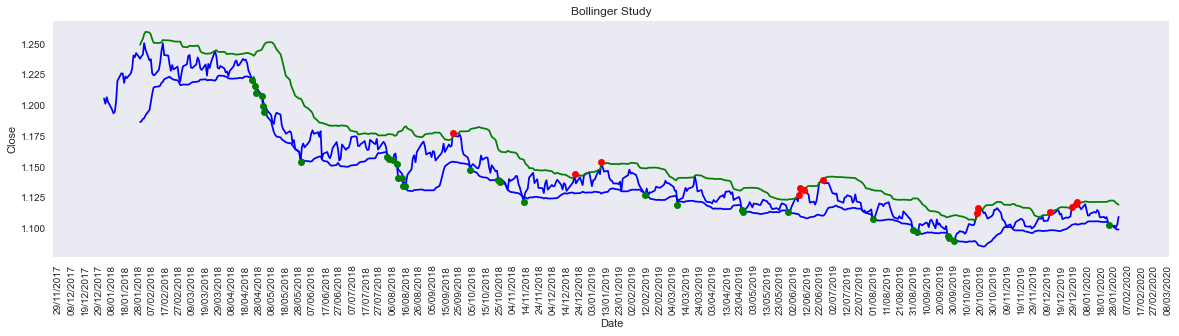

In [20]:
plt.figure(figsize=default_fig_size)
ax = plt.subplot(411)
ax.grid()
ax.set_title(u"Bollinger Study")
ax.xaxis.set_major_locator(DayLocator(interval=10))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.plot(df['close'], 'b', df['bb_bbh'], 'g', df['bb_bbl'], 'b', close_sell_signal, 'ro', close_buy_signal, 'go')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Close')

### Volume Study

In [ ]:
obv = OnBalanceVolumeIndicator(close=df["close"], volume=df['tick_volume'])
obv_values = obv.on_balance_volume()

In [ ]:
plt.figure(figsize=default_fig_size)
ax = plt.subplot(411)
ax.grid()
ax.set_title(u"Volume Study")
ax.xaxis.set_major_locator(DayLocator(interval=10))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.plot(obv_values, 'b')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Close')

### Get/Send Order

In [25]:
obv = OnBalanceVolumeIndicator(close=df["close"], volume=df['tick_volume'])
obv_values = obv.on_balance_volume()

Text(0, 0.5, 'Close')

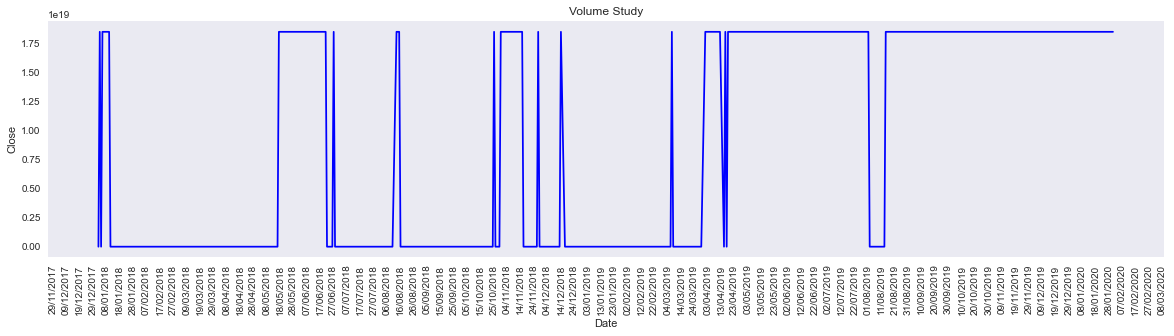

In [26]:
plt.figure(figsize=default_fig_size)
ax = plt.subplot(411)
ax.grid()
ax.set_title(u"Volume Study")
ax.xaxis.set_major_locator(DayLocator(interval=10))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.plot(obv_values, 'b')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Close')

### Get/Send Order

In [11]:
orders=mt5.orders_get(symbol="GBPUSD")
orders

()

In [12]:
# TODO SEND ORDER

### Shutdown MT5

In [13]:
mt5.shutdown()

True